# Binary Classification in Keras

## Introduction

<center><img src="Images/nn_image.jpg"> </center>
    
[image by fdecomite](https://www.flickr.com/photos/fdecomite/3238821080)

In this notebook you will learn how to train a neural network to perform classification tasks in Keras.  This lesson will cover common preprocessing requirements, necessary model architecture, and model evaluation.

This notebook assumes that you have completed the previous lessons on forward propagation, backward propagation, and regression in Keras.  It also assumes that you have installed Keras, Pandas, and Scikit-Learn in your environment.

## Lesson Outline
1. Review Neural Networks
2. Binary Classification, Multi-class Classification, and Regression
3. Preparing data
4. Building your model
5. Evaluating your model

## Review

### Multi-Layered Perceptrons
In the previous lessons, you learned about densely connected feed-forward neural networks. These are also commonly called MLPs or Multi-Layered Perceptrons.

### Model Structure and Forward Propagation

#### Nodes and Layers
You learned that these models make predictions by ingesting data into their input layers and passing the data through some number of hidden layers. Finally, an output layer produces a prediction.  You learned that the input layer has one node for each feature in the training data, each hidden layers can have any number of nodes, and that the number of nodes in the output layer depends on the type of problem your model is solving.

#### Parameters
In an MLP, the outputs of all nodes in one layer are passed to all nodes in the next layer.  Each node has a number of weights equal to its number of inputs plus one bias term.  These are collectively called parameters and form the 'intelligence' of the model.  Parameters change as the model learns to make better predictions.

#### Activation Functions
You also learned that hidden layers should each have a non-linear activation function to allow the model to find non-linear patterns in the data.  While activation functions in the hidden layers can be chosen by the model creator, the activation function in the output layer is dependent on the problem being solved.  Input layers should not have activation functions.

#### Cost Functions
You also learned about the cost functions which models use to determine the success of their predictions.  These functions help them determine how to change the parameters of each node in each learning epoch.  This cost function, like the output layer, will be specific to the problem being solved.

### Backward Propagation and Gradient Descent.
Finally, you learned about gradient descent, which tells a model how and how much to change each parameter.  The process of backward propagation applies gradient descent to each layer of the model, starting at the output and moving backward to the input.

### Keras
In the previous lesson you learned how to use the Keras API with a Tensorflow backend to easy construct and train neural networks.  You used the `Sequential` model type and `Input` and `Dense` layers to construct, compile, and train a model.

## Binary Classification, Multi-class Classification, and Regression.

Recall that classification models classify samples into one of a limited number of predefined groups, or classes.  Regression models, on the other hand, predict a quantity that can theoretically have any value.  Classification models answer questions such as 'Which or what group does this sample fit in?", while regression models answer questions such as 'How much or how many?"

### Binary vs Multi-class classification

Binary classification is very common and these kinds of models classify samples into one of two groups.  Multiclass classification models classify samples into one of three or more groups.

This distinction is important in machine learning as many classification metrics, such as precision, recall, ROC-AUC, f1-score, and PR-AUC assume there are two classes.  The distinction is also important in neural networks because it changes the number of output nodes, the activation function of the output nodes, and the loss function the model will apply.

Multi-class classification in Keras will be reviewed in more detail in a future lesson.

### Binary Classification

Binary classification is often (but not always) used to separate 'normal' data from data representing some event or condition of interest, such as in hypothesis testing, such as in detecting fraud, spam, or disease.  We often use the same language such as true and false positives and true and false negatives.  One class in the binary is sometimes considered the 'positive class' or the thing we are trying to detect and one class is considered the 'negative' class, or data without the effect or condition we are detecting.

Other times we have two categories of equal interest.  In these cases, we may be interested in the metrics for both classes equally.

## The Data

In previous lessons using classification data, we used the Iris Dataset.  We transformed it from multi-class to binary classification by removing one of the classes.  In this notebook we will try a new dataset.  The Iris Dataset is very popular among beginner data scientists, but it is also a very small dataset.  Neural networks and deep learning models are better suited to larger datasets.

### Employee Retention

The dataset we will use in this lesson is the Employee Dataset.  It contains anonymized information about employees at an unnamed company, notably including data about whether they will leave the company in the next year.  It was downloaded and adapted from [Kaggle](https://www.kaggle.com/datasets/tawfikelmetwally/employee-dataset?resource=download) and was contributed to the Kaggle by [TAWFIK ELMETWALLY](https://www.kaggle.com/tawfikelmetwally)

#### Data Dictionary

**Education**: The educational qualifications of employees, including degree, institution, and field of study.

**Joining Year**: The year each employee joined the company, indicating their length of service.

**City**: The location or city where each employee is based or works.

**Payment Tier**: Categorization of employees into different salary tiers.

**Age**: The age of each employee, providing demographic insights.

**Gender**: Gender identity of employees, promoting diversity analysis.

**Ever Benched**: Indicates if an employee has ever been temporarily without assigned work.

**Experience in Current Domain**: The number of years of experience employees have in their current field.

**Leave or Not**: a target column

In [8]:
## Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

##sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
set_config(transform_output='pandas') ## Set sklearn transformers to output Pandas dataframes

##keras
from keras import layers, losses, optimizers, metrics, models

### EDA

In [9]:
## Load and Inspect Data
df = pd.read_csv('data/Employee.csv')
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,Stay
1,Bachelors,2013,Pune,1,28,Female,No,3,Leave
2,Bachelors,2014,New Delhi,3,38,Female,No,2,Stay
3,Masters,2016,Bangalore,3,27,Male,No,5,Leave
4,Masters,2017,Pune,3,24,Male,Yes,2,Leave


#### Data Notes

1. **Categorical Data**:  Like Scikit-Learn models, Keras models require that all features is in numeric format.  We will need to one-hot encode categorical data, such as Education, City, Gender, and EverBenched.

Unlike Scikit-Learn classification models, Keras models will not accept strings as labels.  We will also need to encode the target variable.

In [10]:
## Datatypes and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   object
dtypes: int64(4), object(5)
memory usage: 327.3+ KB


2. **Missing Data**: There are non NaNs in our dataset, that is good.  

Scikit-Learn models will return errors if there are missing values, but Keras models will not!  However, Keras models will fail to properly converge when values are missing.  This can be a very frusterating silent error, so remember to always do proper EDA and data preparation.  Missing values must be dropped or imputed.

In [11]:
##Summary Statistics
df.describe(include='all')

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
count,4653,4653.000000,4653,4653.000000,4653.000000,4653,4653,4653.000000,4653
unique,3,NaN,3,NaN,NaN,2,2,NaN,2
top,Bachelors,NaN,Bangalore,NaN,NaN,Male,No,NaN,Stay
freq,3601,NaN,2228,NaN,NaN,2778,4175,NaN,3053
mean,NaN,2015.062970,NaN,2.698259,29.393295,NaN,NaN,2.905652,NaN
std,NaN,1.863377,NaN,0.561435,4.826087,NaN,NaN,1.558240,NaN
min,NaN,2012.000000,NaN,1.000000,22.000000,NaN,NaN,0.000000,NaN
25%,NaN,2013.000000,NaN,3.000000,26.000000,NaN,NaN,2.000000,NaN
50%,NaN,2015.000000,NaN,3.000000,28.000000,NaN,NaN,3.000000,NaN
75%,NaN,2017.000000,NaN,3.000000,32.000000,NaN,NaN,4.000000,NaN


3. **Summary Stats and Class Balance**: There don't seem to be any surprises in our exploration of these summary statistics.  One important note is that our target classes are not balanced. This is always important to note with classification modeling.  If our classes are strongly imbalanced, we might need to take steps to balance them to avoid model bias.

### Data Preparation

In this section we will prepare our data for modeling.  There are 4 transformations we must make:

1. X/y and Train/test split data
2. Encode class labels as numbers
3. Encode categorical features as numeric
4. Scale all data

In order to make our preprocessing steps simple and repeatable, we will create a re-useable preprocessing pipeline.  

In [12]:
## Split features and target
target = 'LeaveOrNot'
X = df.drop(target, axis=1)
y = df[target].copy() ## make a copy to avoid mutating original data

## Encode Labels
y = y.apply(lambda x: 0 if x == 'Stay' else 1)

## Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
3274,Bachelors,2013,Bangalore,3,35,Male,No,0
2578,PHD,2013,New Delhi,3,27,Female,No,5
3716,Bachelors,2015,Pune,3,32,Female,No,3
2073,Masters,2017,Pune,2,29,Female,No,2
1033,Bachelors,2016,Bangalore,3,28,Male,No,3


The preprocessor below will one-hot encode only the categorical features, scale the numeric columns, and drop any additional columns.  This last step is important for data validation if this pipeline is going to be used in deployment. You don't want someone upstream adding additional columns and breaking your model!

In [15]:
## Create a preprocessor for features

categorical_columns = ['Education', 'City', 'Gender', 'EverBenched']
numeric_columns = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore',
                    drop='if_binary') # Drop one of the columns if the category is binary

scaler = MinMaxScaler()

## Create a tuple for the ColumnTransformer
preprocessor = ColumnTransformer([('Categorical', ohe, categorical_columns),
                                  ('Numeric', scaler, numeric_columns)],
                                    verbose_feature_names_out=False,
                                    remainder='drop')

In [16]:
X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)
X_train_proc.head()

,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain
3274,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.166667,1.0,0.684211,0.000000
2578,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.166667,1.0,0.263158,0.714286
3716,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.500000,1.0,0.526316,0.428571
2073,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.833333,0.5,0.368421,0.285714
1033,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.666667,1.0,0.315789,0.428571


## Construct Model

In the last lesson we just constructed the model in a cell.  However, there are many reasons to define a function to create our model instead.  This approach opens up some possibilities for auto-tuning models and using Keras models with various other packages.  We will cover these in future lessons, but it's a good habit to get into now.

Our function will:

1. Instantiate a Keras `Sequential` model
2. Add an `Input` layer with the proper shape, according to the number of input features
3. Add 2 hidden layers of 64 units each with ReLU activations.

In the previous lesson we used a simoid activation for the hidden layers, but ReLU is a more popular choice for hidden layers.  This is because the calculation is very simple and it tends to regularize models by 'turning off' certain unneeded nodes, setting their outputs to 0.

ReLU is simply understand as the maximum of the function input or 0.  `max(x, 0)`.  Any negative input is mapped to 0 and any positive output is returned unchanged.

5. Add an output layer with one node and a sigmoid activation function.  

Our model will predict a number between 0 and 1 for each sample.  This value will be the probability that this sample is a member of class 1 (leaving the company).  **This makes the output layer a logistic regression model.**  

6. Compile the model with **Binary Crossentropy** as the loss function.  

This metric be lower if the model predictions are closer to the correct classes, as is required for a loss function..  

In the last lesson we used the `Adam` optimizer, but this time we will try a `Nadam` optimizer.  This is an extention to the `Adam` optimizer that uses a Nesterov momentum, which is an improved type of momentum. ([Gradient Descent Optimization With Nadam From Scratch, Machine Learning Mastery](https://machinelearningmastery.com/gradient-descent-optimization-with-nadam-from-scratch/#:~:text=Mini%2DCourse%20now!-,Nadam%20Optimization%20Algorithm,an%20improved%20type%20of%20momentum.))  Remember, there are many kinds of optimizers and the choice is yet another hyperparameter to tune.

Finally, we will ask the model to keep track of several classification metrics for each epoch as it learns, accuracy, precision, recall, and ROC AUC.  Notice that we access `'accuracy'` using a string, but pass other metrics as instantiated class objects.  Keras is fiercely object oriented and much more so than Scikit-Learn.  Even things like metrics are represented as objects in this package.

In [17]:
## Save the input dimensions
input_dims = (X_train_proc.shape[1],)

## Define the Function
def make_model(input_dims):
    """Creates and returns as Keras model suitable for binary classification of tabular data.  
    Arguments:
    input_dims: The number of input features in the tabular data"""
    
    ## Instantiate the model
    model = models.Sequential()

    ## Construct model architecture
    ## input layer
    model.add(layers.Input(shape=input_dims, name='input'))
    ## hidden layers
    model.add(layers.Dense(units=64, activation='relu', name='hidden_1'))
    model.add(layers.Dense(units=64, activation='relu', name='hidden_2'))
    ## output layer
    model.add(layers.Dense(units=1, activation='sigmoid', name='output')) ## one output

    ## Compile the model with binary crossentropy, Nadam Optimizer, and 

    model.compile(loss=losses.BinaryCrossentropy(),
                  optimizer=optimizers.Nadam(),
                  metrics=['accuracy',
                           metrics.Precision(),
                           metrics.Recall(),
                           metrics.AUC()])
    
    return model

In [18]:
## Instantiate and examine the model
model = make_model(input_dims)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)                │        832 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ hidden_2 (Dense)                │ (None, 64)                │      4,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ output (Dense)                  │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 5,057 (19.75 KB)

 Trainable params: 5,057 (19.75 KB)

 Non-trainable params: 0 (0.00 B)

We can see the shape of the model above.  Remember that with dense layers each node has a weight for each input, plus a bias.  The second hidden layer has many trainable parameters: One for each node in the first hidden layer, for each node in the second hidden layer, and a bias for each node in the second hidden layer.  In this way, the number of nodes in a dense network can balloon quickly and models can become computationally expensive to train, even with TensorFlow's efficient operation.

parameters in hidden_2 = (nodes in hidden_1 * nodes in hidden_2) + nodes in hidden_2

### Model Training

Next, we will train the model on the training data.  We will also set the model create a validation split of the training data as it trains. This way we can monitor for overfitting while still saving our testing data for evaluation of our final model.

#### Validation Split
We can ask the model to set aside some of the training data with the `validation_split=` argument.  We pass a float representing the portion of the data to include for validation.


#### History
We will also save the training history to examine after training completes.  The model history will include the metrics we specified during the compile step for both the training data and the validation data.  If the model starts to overfit on the data, we will be able to see at which epoch this started at and adjust training accordingly.

In [19]:
%%time
### Train the model and save the history
history = model.fit(X_train_proc, y_train,
                    validation_split=0.2,
                    epochs=200,
                    verbose=False)

CPU times: total: 11 s
Wall time: 34.2 s


### Training History

By saving and plotting the training history of our model we can see the patterns of learning.  By including validation data we can also identify overfitting and even at which training epoch it began.

Once a deep learning model starts overfitting, it does not correct itself.  The phenomenon of overfitting after a certain number of training epochs is called 'over-training'.

We will define a function below to plot training histories.  This is a good idea since if we were doing thorough model developement, we may be plotting the histories of many models with different architectures and hyperparameters.

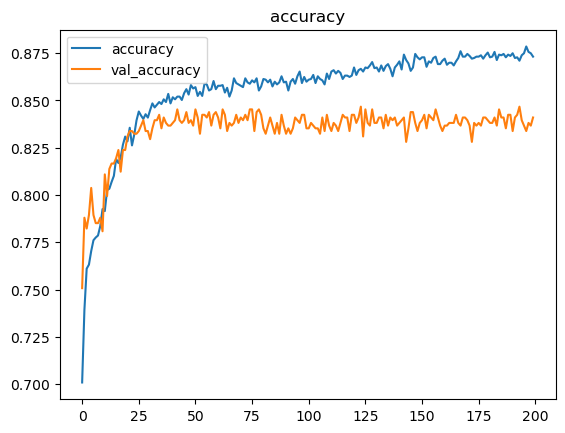

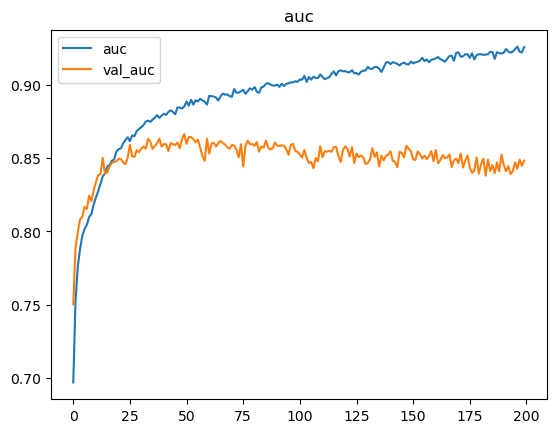

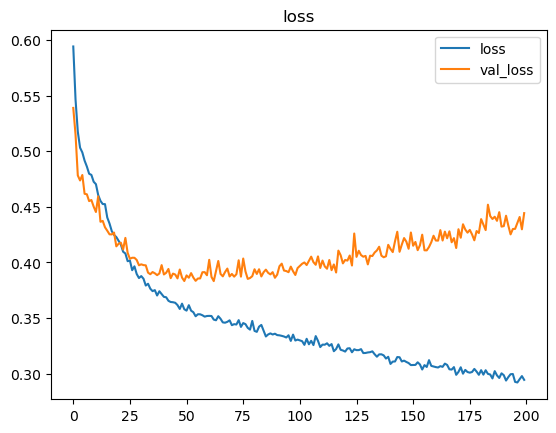

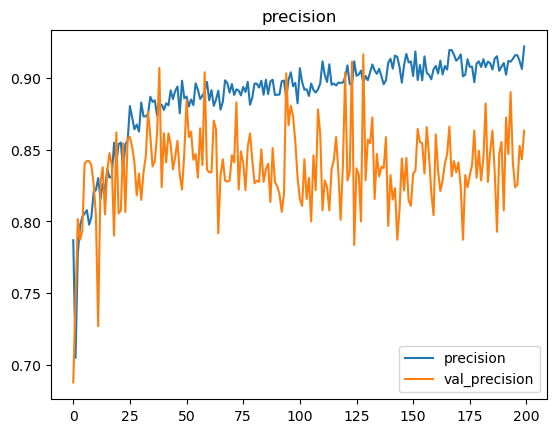

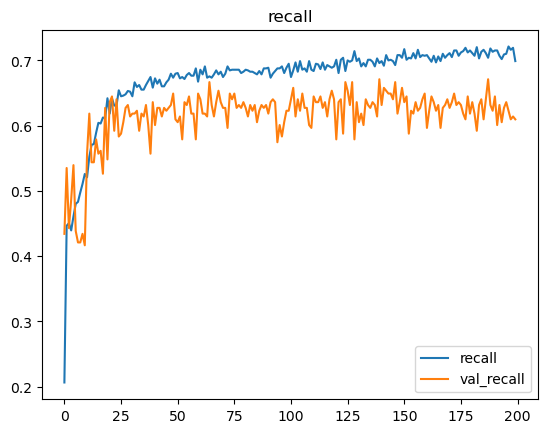

In [20]:
## examine training history
def plot_history(history):
    """Plots all metrics in a Keras Model history.  If validation metrics are included,
    this function will plot them as well.
    Arguments: history - a Keras History object"""
    
    ## Loop over the keys in the histor.history dictionary.  Each represents
    ## either the training or validation measures for a metric
    for metric in history.history.keys():
        ## If the key is not related to validation data
        if not metric.startswith('val_'):
            ## Plot the change in metric over the epochs.
            plt.plot(history.history[metric], label=metric)
            ## If a validation version of the metric exists
            if f'val_{metric}' in history.history.keys():
                ## Plot that on the same plot
                plt.plot(history.history[f'val_{metric}'],
                        label=f'val_{metric}')
            ## Title the plot with the metric
            plt.title(metric)
            ## Show the legend to differentiate training and testing metrics
            plt.legend()
            ## Show each plot separately for each metric.
            plt.show()

## Plot the learning history
plot_history(history)

In the plots above we can see that while the model loss on the training data continues to fall.  

However, after a certain point the model loss as measured on the validation data begins to increase!   This is the beginning of overfitting due to over-training.  If we were to continue model development, we would consider applying regularization techniques or training fewer epochs.

You will learn more about these strategies in future lessons.

### Model Evaluation

Training histories are informative, but it's also important to evaluate our models with other tools to the full picture of our final trained model.  This practice helps us to compare different models to determine which may be best suited to deployment.  We can only understand the performance of classification models when we measure them with multiple metrics.

We will use Scikit-Learn tools for this, but they require whole numbers as inputs.  We can convert our model probabilities to model class predictions by simply rounding the predictions to the nearest whole number: 0 or 1.  

#### Probability Thresholds
Rounding sets a threshold of 50% for prediction.  Any sample that the model predicts to have a 50% or greater probability of being class 1 (an employee who leaves), will be classified as class 1.

We could set a different threshold if we chose, by using a lambda function to convert the predictions, but we will stick to a 50% probablity threshold for this lesson.

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step
Training Metrics
              precision    recall  f1-score   support

        Stay       0.85      0.97      0.91      2278
       Leave       0.93      0.69      0.79      1211

    accuracy                           0.87      3489
   macro avg       0.89      0.83      0.85      3489
weighted avg       0.88      0.87      0.87      3489

Testing Metrics
              precision    recall  f1-score   support

        Stay       0.86      0.95      0.90       775
       Leave       0.88      0.68      0.77       389

    accuracy                           0.86      1164
   macro avg       0.87      0.82      0.83      1164
weighted avg       0.86      0.86      0.86      1164



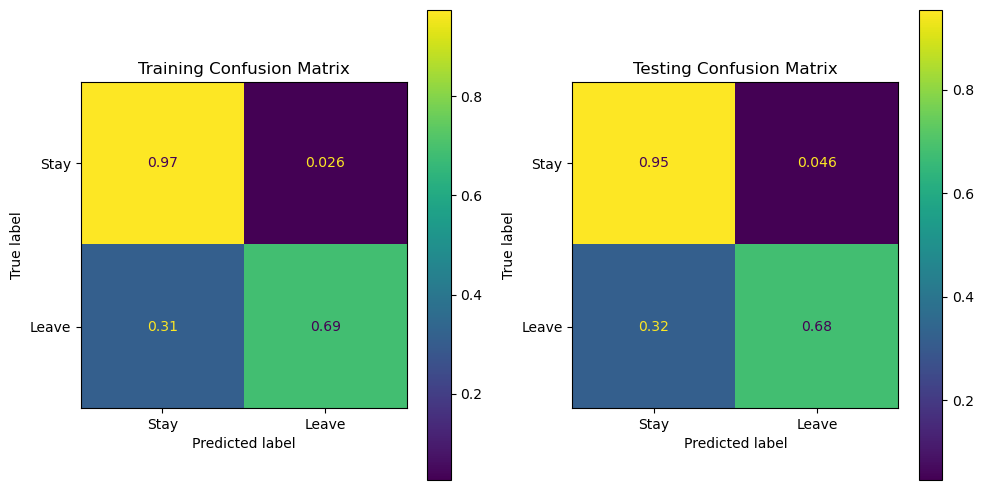

In [21]:
## Get predictions and round to whole numbers
train_probs = model.predict(X_train_proc) # Get model predictions
test_probs = model.predict(X_test_proc)

train_preds = np.rint(train_probs) # round to whole numbers
test_preds = np.rint(test_probs)

## Classification Reports
labels=['Stay','Leave']

print('Training Metrics')
print(classification_report(y_train, train_preds, target_names=labels))
print('Testing Metrics')
print(classification_report(y_test, test_preds, target_names=labels))

## Confusion Matrices
fig, axes = plt.subplots(1,2, figsize=(10,5))
ConfusionMatrixDisplay.from_predictions(y_train, train_preds, ax=axes[0],
                                        normalize='true', display_labels=labels)
axes[0].set_title('Training Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, test_preds, ax=axes[1],
                                        normalize='true', display_labels=labels)
axes[1].set_title('Testing Confusion Matrix')
plt.tight_layout()



Our model did not overfit badly, but we would expect that if we continued training, the training and testing metrics would continue to diverge.  

We can also see from our metrics that our model was better able to detect employees who would stay with the company than those that would leave, since the recall was better on the 'Stay' class than the 'Leave' class. We might consider class balancing techniques for our next attempts, or we may do more research and analysis into why it may be harder to predict employees who are likely to leave the company.  Perhaps we would investigate their reasons for leaving to determine what proportion of these reasons are predictable and which may be more difficult to predict.

If we want to improve this model, we can continue tuning the hyperparameters.  However, if we are happy with this model and would like to use it in other notebooks, or put it into production, we can save it quite simply.

In [22]:
## Saving a Model
model_path = 'models/binary_model.keras'
model.save(model_path)

del model

## loading a model
model = models.load_model(model_path)
model.evaluate(X_test_proc, y_test)

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8624 - auc: 0.8861 - loss: 0.3595 - precision: 0.8894 - recall: 0.6976   


[0.3484387695789337,
 0.8616838455200195,
 0.8861297965049744,
 0.8799999952316284,
 0.6786632537841797]

# Conclusion

In this lesson you learned how to build a Keras model for binary classification.  You learned about the differences in the final layer activation functions and loss functions between regression and binary classification.  You also learned to round the model predictions to allow you to use Scikit-Learn metrics functions for evaluation.

# Challenges:
1. Try to improve on this model.  What would you try next?  You might want to consider:
    * More or fewer layers
    * More or fewer nodes
    * Different activations in the hidden layers (Do not change the final layer activation!)\
    * Different optimizers
    * Class balancing strategies such as oversampling, undersampling, or SMOTE